In [1]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

from model import MLP


## Example

In [2]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Work in progress

In [ ]:
class Simple(Optimizer):
    r"""
    """

    def __init__(self, params, lr, decay, discount):
        defaults = dict(lr=lr, decay=decay, discount=discount)
        if lr <= 0:
            raise ValueError("learning rate (step size) must be strickly positive.")
        if not (0 <= decay <= 1):
            raise ValueError("trace-decay rate must be between 0 and 1.")
        if not (0 <= discount <= 1):
            raise ValueError("discount factor must be between 0 and 1.")
        super(SGD, self).__init__(params, defaults)
        
        #
        self.eligibilities  = dict()
        self.I = 1
        
        # initialise eligibilities ([re]set to zero(0))
        for i, group in enumerate(self.param_groups):
            zs = dict()
            for p in group["params"]:
                zs[p] = torch.zeros_like(p.data)
            self.eligibilities[i] = zs

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)

    def step(self, closure=None):
        """
        """
        loss = None
        if closure is not None:
            loss = closure()
                
        # update parameters  
        for i, group in enumerate(self.param_groups):
            _alpha = group["lr"]
            _lambda = group["decay"]
            _gamma = group["decay"]
            for p in group["params"]:
                if p.grad is None:
                    continue
                # retrieve current eligibility
                z = self.eligibilities[i][p]
                # retrieve current gradient
                grad = p.grad.data
                # update eligibility
                z.mul_(_gamma * _lambda_critic).add_(I, grad)
                # update parameters
                p.data.add_(_alpha_critic * _delta, z)
                
        #
        self.I = _gamma * self.I
        return loss

In [3]:
class Actor(nn.Module):

    def __init__(self, inp_size, h_sizes, out_size, nonlinearity, init_type, verbose=False):

        super(Actor, self).__init__()

        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(inp_size, h_sizes[0])])
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))

        # Output layer
        self.out = nn.Linear(h_sizes[-1], out_size)

        # Initializes the parameters
        self.init_parameters(init_type)

        if verbose:
            print('\nModel Info ------------')
            print(self)
            print("Total number of parameters : {:.2f} k".format(self.get_number_of_params() / 1e3))
            print('---------------------- \n')

    def forward(self, x):

        # Feedforward
        for layer in self.hidden:
            a = layer(x)
            x = F.elu(a)

        output = F.softmax(self.out(x), dim=1)

        return output

    def init_parameters(self, init_type):

        for module in self.modules():
            if isinstance(module, nn.Linear):

                nn.init.constant(module.bias, 0)

                if init_type == "glorot":
                    nn.init.xavier_normal(module.weight, gain=nn.init.calculate_gain("relu"))

                elif init_type == "standard":
                    stdv = 1. / np.sqrt(module.weight.size(1))
                    nn.init.uniform(module.weight, -stdv, stdv)

        for p in self.parameters():
            p.requires_grad = True

    def get_number_of_params(self):

        total_params = 0

        for params in self.parameters():

            total_size = 1
            for size in params.size():
                total_size *= size

            total_params += total_size

        return total_params

    def name(self):
        return "PolicyNetwork"

In [4]:
# a policy estimator (actor)
actor = Actor(len(env.observation_space.sample()), [128], env.action_space.n, "relu", "standard", verbose=True)
if torch.cuda.is_available():
    actor = actor.cuda()


Model Info ------------
Actor(
  (out): Linear(in_features=4, out_features=2, bias=False)
)
Total number of parameters : 0.01 k
---------------------- 



In [5]:
class Critic(nn.Module):

    def __init__(self, inp_size, h_sizes, out_size, nonlinearity, init_type, verbose=False):

        super(Critic, self).__init__()

        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(inp_size, h_sizes[0])])
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))

        # Output layer
        self.out = nn.Linear(h_sizes[-1], out_size)

        # Initializes the parameters
        self.init_parameters(init_type)

        if verbose:
            print('\nModel Info ------------')
            print(self)
            print("Total number of parameters : {:.2f} k".format(self.get_number_of_params() / 1e3))
            print('---------------------- \n')

    def forward(self, x):

        # Feedforward
        for layer in self.hidden:
            a = layer(x)
            x = F.elu(a)

        output = self.out(x)

        return output

    def init_parameters(self, init_type):

        for module in self.modules():
            if isinstance(module, nn.Linear):

                nn.init.constant(module.bias, 0)

                if init_type == "glorot":
                    nn.init.xavier_normal(module.weight, gain=nn.init.calculate_gain("relu"))

                elif init_type == "standard":
                    stdv = 1. / np.sqrt(module.weight.size(1))
                    nn.init.uniform(module.weight, -stdv, stdv)

        for p in self.parameters():
            p.requires_grad = True

    def get_number_of_params(self):

        total_params = 0

        for params in self.parameters():

            total_size = 1
            for size in params.size():
                total_size *= size

            total_params += total_size

        return total_params

    def name(self):
        return "ValueNetwork"

In [6]:
# a state-value estimator (critic)
critic = Critic(len(env.observation_space.sample()), [128], 1, "relu", "standard", verbose=True)
if torch.cuda.is_available():
    critic = critic.cuda()


Model Info ------------
Critic(
  (out): Linear(in_features=4, out_features=1, bias=False)
)
Total number of parameters : 0.00 k
---------------------- 



In [7]:
# inputs: a differentiable policy parameterization,
#         a differentiable state-value parameterization.
#
# parameters: trace-decay rates for policy and state-value,
#             step sizes for policy and state-value,
#             discount factor.
#
# initialise policy parameters and state-value weights
# repeat forever (for each episode)
#   initialise S (select a starting state for the episode)
#   initialise eligibilities (policy and state-value)
#   I = 1
#   while S is not terminal (for each time step)
#     select action A from policy
#     take action A and observe next state S' and reward R
#     compute TD error (if S' is terminal, then v(S', w)=0)
#     update eligibilities (policy and state-value)
#     update policy parameters and state-value weights
#     I = $\gamma$ * I
#     update current state to next state (S = S')

In [8]:
#
n_episodes=6000
_gamma=0.99
_lambda_critic=0.9
_lambda_actor=0.9
_alpha_critic=1e-5
_alpha_actor=1e-3
_optim = torch.optim.SGD


In [ ]:
#
critic_optimizer = _optim(critic.parameters(), lr=_alpha_critic)
actor_optimizer  = _optim(actor.parameters(), lr=_alpha_actor)

#
try:
    rewards = []
    for n in range(n_episodes):
        # initialise S (select a starting state for the episode)
        state = env.reset()
        # to torch.autograd.Variable
        state = Variable(torch.Tensor([state]))        
        if torch.cuda.is_available():
            state = state.cuda()

        #
        critic_eligibilities = dict()
        actor_eligibilities  = dict()
        I = 1

        # initialise critic eligibilities ([re]set to zero(0))
        for i, group in enumerate(critic_optimizer.param_groups):
            zs = dict()
            for p in group["params"]:
                zs[p] = torch.zeros_like(p.data)
            critic_eligibilities[i] = zs

        # initialise actor eligibilities ([re]set to zero(0))
        for i, group in enumerate(actor_optimizer.param_groups):
            zs = dict()
            for p in group["params"]:
                zs[p] = torch.zeros_like(p.data)
            actor_eligibilities[i] = zs

        #
        cum_rewards = []
        cum_reward = 0
        done = False
        t = 0
        while not done:
            # render the environment
            env.render()

            # select action from policy
            probas = actor(state)
            # action = int(torch.max(probas, 1)[1].cpu().data)
            action = int(probas.multinomial().data)
            # take action A and observe next state S' and reward R
            observation, reward, done, _ = env.step(action)
            # to torch.autograd.Variable
            observation = Variable(torch.Tensor([observation]))        
            if torch.cuda.is_available():
                observation = observation.cuda()
            #
            cum_reward += reward
            cum_rewards.append(cum_reward)
            # compute TD error (if S' is terminal, then v(S', w)=0)
            error = reward + (_gamma * critic(observation)) - critic(state) # if not done else reward - critic(state)
            _delta = error.cpu().data
            
            #
            v = critic(state)
            v.backward()
            # set model parameters' gradients to updated eligibilities
            critic_optimizer.zero_grad()
            for i, group in enumerate(critic_optimizer.param_groups):

                for p in group["params"]:
                    if p.grad is None:
                        continue
                    # retrieve current eligibility
                    z = critic_eligibilities[i][p]
                    # retrieve current gradient
                    grad = p.grad.data
                    # update eligibility
                    #
                    # torch.nn.utils.clip_grad_norm(critic.parameters(), 1.0)
                    z.mul_(_gamma * _lambda_actor).add_(I, grad)
                    # set gradient
                    p.grad.data = -_delta * z
            
            # call the usual optimizer
            critic_optimizer.step()

            #
            probas = actor(state)
            log_proba = torch.log(probas)[:, action]
            log_proba.backward()
            # set model parameters' gradients to updated eligibilities            
            actor_optimizer.zero_grad()
            for i, group in enumerate(actor_optimizer.param_groups):

                for p in group["params"]:
                    if p.grad is None:
                        continue
                    # retrieve current eligibility
                    z = actor_eligibilities[i][p]
                    # retrieve current gradient
                    grad = p.grad.data
                    # update eligibility
                    #
                    # torch.nn.utils.clip_grad_norm(actor.parameters(), 1.0)
                    z.mul_(_gamma * _lambda_actor).add_(I, grad)
                    # set gradient
                    p.grad.data = -_delta * z
            
            # call the usual optimizer
            actor_optimizer.step()

            #
            I = _gamma * I
            t = t + 1
            # update current state to next state (S = S')
            state = observation
        #
        print("episode {}, {} steps.".format(n+1, t+1))
        rewards.append(cum_rewards)
    # close environment
    env.close()

    #
    for rs in rewards:
        plt.plot(rs)
    plt.grid(True)
    plt.show()
finally:
    env.close()

episode 1, 22 steps.
episode 2, 23 steps.
episode 3, 16 steps.
episode 4, 15 steps.
episode 5, 19 steps.
episode 6, 10 steps.
episode 7, 17 steps.
episode 8, 20 steps.
episode 9, 13 steps.
episode 10, 23 steps.
episode 11, 10 steps.
episode 12, 18 steps.
episode 13, 12 steps.
episode 14, 19 steps.
episode 15, 16 steps.
episode 16, 20 steps.
episode 17, 26 steps.
episode 18, 22 steps.
episode 19, 14 steps.
episode 20, 42 steps.
episode 21, 17 steps.
episode 22, 59 steps.
episode 23, 27 steps.
episode 24, 29 steps.
episode 25, 13 steps.
episode 26, 15 steps.
episode 27, 27 steps.
episode 28, 22 steps.
episode 29, 14 steps.
episode 30, 9 steps.
episode 31, 36 steps.
episode 32, 16 steps.
episode 33, 27 steps.
episode 34, 11 steps.
episode 35, 13 steps.
episode 36, 28 steps.
episode 37, 41 steps.
episode 38, 29 steps.
episode 39, 33 steps.
episode 40, 28 steps.
episode 41, 19 steps.
episode 42, 22 steps.
episode 43, 20 steps.
episode 44, 28 steps.
episode 45, 14 steps.
episode 46, 18 steps

episode 362, 62 steps.
episode 363, 79 steps.
episode 364, 56 steps.
episode 365, 66 steps.
episode 366, 77 steps.
episode 367, 53 steps.
episode 368, 69 steps.
episode 369, 70 steps.
episode 370, 102 steps.
episode 371, 27 steps.
episode 372, 41 steps.
episode 373, 47 steps.
episode 374, 111 steps.
episode 375, 66 steps.
episode 376, 86 steps.
episode 377, 15 steps.
episode 378, 145 steps.
episode 379, 48 steps.
episode 380, 41 steps.
episode 381, 22 steps.
episode 382, 109 steps.
episode 383, 134 steps.
episode 384, 18 steps.
episode 385, 26 steps.
episode 386, 36 steps.
episode 387, 79 steps.
episode 388, 36 steps.
episode 389, 123 steps.
episode 390, 65 steps.
episode 391, 160 steps.
episode 392, 96 steps.
episode 393, 74 steps.
episode 394, 104 steps.
episode 395, 107 steps.
episode 396, 176 steps.
episode 397, 117 steps.
episode 398, 101 steps.
episode 399, 38 steps.
episode 400, 93 steps.
episode 401, 69 steps.
episode 402, 34 steps.
episode 403, 54 steps.
episode 404, 80 steps.

episode 711, 88 steps.
episode 712, 153 steps.
episode 713, 89 steps.
episode 714, 151 steps.
episode 715, 86 steps.
episode 716, 174 steps.
episode 717, 157 steps.
episode 718, 146 steps.
episode 719, 127 steps.
episode 720, 226 steps.
episode 721, 217 steps.
episode 722, 193 steps.
episode 723, 386 steps.
episode 724, 70 steps.
episode 725, 173 steps.
episode 726, 199 steps.
episode 727, 131 steps.
episode 728, 93 steps.
episode 729, 72 steps.
episode 730, 190 steps.
episode 731, 38 steps.
episode 732, 111 steps.
episode 733, 187 steps.
episode 734, 183 steps.
episode 735, 105 steps.
episode 736, 172 steps.
episode 737, 55 steps.
episode 738, 83 steps.
episode 739, 139 steps.
episode 740, 199 steps.
episode 741, 245 steps.
episode 742, 211 steps.
episode 743, 86 steps.
episode 744, 100 steps.
episode 745, 233 steps.
episode 746, 42 steps.
episode 747, 105 steps.
episode 748, 177 steps.
episode 749, 237 steps.
episode 750, 119 steps.
episode 751, 170 steps.
episode 752, 126 steps.
epi

episode 1053, 104 steps.
episode 1054, 72 steps.
episode 1055, 158 steps.
episode 1056, 151 steps.
episode 1057, 42 steps.
episode 1058, 250 steps.
episode 1059, 263 steps.
episode 1060, 70 steps.
episode 1061, 279 steps.
episode 1062, 144 steps.
episode 1063, 148 steps.
episode 1064, 164 steps.
episode 1065, 36 steps.
episode 1066, 102 steps.
episode 1067, 141 steps.
episode 1068, 263 steps.
episode 1069, 50 steps.
episode 1070, 284 steps.
episode 1071, 126 steps.
episode 1072, 132 steps.
episode 1073, 221 steps.
episode 1074, 172 steps.
episode 1075, 150 steps.
episode 1076, 70 steps.
episode 1077, 148 steps.
episode 1078, 203 steps.
episode 1079, 80 steps.
episode 1080, 130 steps.
episode 1081, 121 steps.
episode 1082, 53 steps.
episode 1083, 85 steps.
episode 1084, 186 steps.
episode 1085, 81 steps.
episode 1086, 124 steps.
episode 1087, 110 steps.
episode 1088, 86 steps.
episode 1089, 311 steps.
episode 1090, 220 steps.
episode 1091, 245 steps.
episode 1092, 31 steps.
episode 1093

episode 1383, 220 steps.
episode 1384, 203 steps.
episode 1385, 53 steps.
episode 1386, 119 steps.
episode 1387, 151 steps.
episode 1388, 221 steps.
episode 1389, 127 steps.
episode 1390, 139 steps.
episode 1391, 197 steps.
episode 1392, 173 steps.
episode 1393, 127 steps.
episode 1394, 196 steps.
episode 1395, 258 steps.
episode 1396, 134 steps.
episode 1397, 78 steps.
episode 1398, 142 steps.
episode 1399, 222 steps.
episode 1400, 182 steps.
episode 1401, 252 steps.
episode 1402, 135 steps.
episode 1403, 163 steps.
episode 1404, 47 steps.
episode 1405, 30 steps.
episode 1406, 123 steps.
episode 1407, 178 steps.
episode 1408, 182 steps.
episode 1409, 148 steps.
episode 1410, 163 steps.
episode 1411, 66 steps.
episode 1412, 149 steps.
episode 1413, 142 steps.
episode 1414, 86 steps.
episode 1415, 343 steps.
episode 1416, 196 steps.
episode 1417, 242 steps.
episode 1418, 318 steps.
episode 1419, 167 steps.
episode 1420, 265 steps.
episode 1421, 197 steps.
episode 1422, 172 steps.
episod

episode 1713, 134 steps.
episode 1714, 324 steps.
episode 1715, 326 steps.
episode 1716, 204 steps.
episode 1717, 260 steps.
episode 1718, 222 steps.
episode 1719, 286 steps.
episode 1720, 206 steps.
episode 1721, 215 steps.
episode 1722, 235 steps.
episode 1723, 501 steps.
episode 1724, 227 steps.
episode 1725, 151 steps.
episode 1726, 306 steps.
episode 1727, 150 steps.
episode 1728, 117 steps.
episode 1729, 260 steps.
episode 1730, 456 steps.
episode 1731, 174 steps.
episode 1732, 397 steps.
episode 1733, 232 steps.
episode 1734, 163 steps.
episode 1735, 207 steps.
episode 1736, 401 steps.
episode 1737, 326 steps.
episode 1738, 205 steps.
episode 1739, 212 steps.
episode 1740, 194 steps.
episode 1741, 416 steps.
episode 1742, 283 steps.
episode 1743, 184 steps.
episode 1744, 227 steps.
episode 1745, 165 steps.
episode 1746, 209 steps.
episode 1747, 161 steps.
episode 1748, 233 steps.
episode 1749, 144 steps.
episode 1750, 179 steps.
episode 1751, 186 steps.
episode 1752, 156 steps.


episode 2041, 347 steps.
episode 2042, 207 steps.
episode 2043, 259 steps.
episode 2044, 178 steps.
episode 2045, 146 steps.
episode 2046, 446 steps.
episode 2047, 298 steps.
episode 2048, 236 steps.
episode 2049, 272 steps.
episode 2050, 70 steps.
episode 2051, 148 steps.
episode 2052, 165 steps.
episode 2053, 194 steps.
episode 2054, 100 steps.
episode 2055, 85 steps.
episode 2056, 192 steps.
episode 2057, 111 steps.
episode 2058, 107 steps.
episode 2059, 188 steps.
episode 2060, 320 steps.
episode 2061, 179 steps.
episode 2062, 177 steps.
episode 2063, 195 steps.
episode 2064, 193 steps.
episode 2065, 173 steps.
episode 2066, 233 steps.
episode 2067, 250 steps.
episode 2068, 181 steps.
episode 2069, 221 steps.
episode 2070, 315 steps.
episode 2071, 98 steps.
episode 2072, 136 steps.
episode 2073, 96 steps.
episode 2074, 114 steps.
episode 2075, 62 steps.
episode 2076, 119 steps.
episode 2077, 373 steps.
episode 2078, 128 steps.
episode 2079, 145 steps.
episode 2080, 134 steps.
episo

episode 2370, 180 steps.
episode 2371, 364 steps.
episode 2372, 277 steps.
episode 2373, 258 steps.
episode 2374, 213 steps.
episode 2375, 173 steps.
episode 2376, 177 steps.
episode 2377, 205 steps.
episode 2378, 309 steps.
episode 2379, 318 steps.
episode 2380, 230 steps.
episode 2381, 225 steps.
episode 2382, 90 steps.
episode 2383, 245 steps.
episode 2384, 66 steps.
episode 2385, 400 steps.
episode 2386, 344 steps.
episode 2387, 90 steps.
episode 2388, 207 steps.
episode 2389, 152 steps.
episode 2390, 501 steps.
episode 2391, 231 steps.
episode 2392, 251 steps.
episode 2393, 305 steps.
episode 2394, 201 steps.
episode 2395, 154 steps.
episode 2396, 164 steps.
episode 2397, 94 steps.
episode 2398, 134 steps.
episode 2399, 194 steps.
episode 2400, 250 steps.
episode 2401, 297 steps.
episode 2402, 278 steps.
episode 2403, 240 steps.
episode 2404, 249 steps.
episode 2405, 270 steps.
episode 2406, 408 steps.
episode 2407, 222 steps.
episode 2408, 304 steps.
episode 2409, 226 steps.
epis

episode 2699, 170 steps.
episode 2700, 217 steps.
episode 2701, 219 steps.
episode 2702, 227 steps.
episode 2703, 257 steps.
episode 2704, 249 steps.
episode 2705, 151 steps.
episode 2706, 150 steps.
episode 2707, 172 steps.
episode 2708, 165 steps.
episode 2709, 43 steps.
episode 2710, 173 steps.
episode 2711, 193 steps.
episode 2712, 135 steps.
episode 2713, 172 steps.
episode 2714, 350 steps.
episode 2715, 188 steps.
episode 2716, 71 steps.
episode 2717, 187 steps.
episode 2718, 209 steps.
episode 2719, 243 steps.
episode 2720, 256 steps.
episode 2721, 189 steps.
episode 2722, 140 steps.
episode 2723, 166 steps.
episode 2724, 167 steps.
episode 2725, 259 steps.
episode 2726, 207 steps.
episode 2727, 123 steps.
episode 2728, 193 steps.
episode 2729, 152 steps.
episode 2730, 183 steps.
episode 2731, 149 steps.
episode 2732, 265 steps.
episode 2733, 261 steps.
episode 2734, 240 steps.
episode 2735, 231 steps.
episode 2736, 207 steps.
episode 2737, 232 steps.
episode 2738, 203 steps.
ep

episode 3027, 261 steps.
episode 3028, 147 steps.
episode 3029, 145 steps.
episode 3030, 229 steps.
episode 3031, 317 steps.
episode 3032, 157 steps.
episode 3033, 133 steps.
episode 3034, 163 steps.
episode 3035, 160 steps.
episode 3036, 213 steps.
episode 3037, 289 steps.
episode 3038, 184 steps.
episode 3039, 228 steps.
episode 3040, 154 steps.
episode 3041, 120 steps.
episode 3042, 365 steps.
episode 3043, 199 steps.
episode 3044, 305 steps.
episode 3045, 224 steps.
episode 3046, 215 steps.
episode 3047, 333 steps.
episode 3048, 230 steps.
episode 3049, 224 steps.
episode 3050, 320 steps.
episode 3051, 250 steps.
episode 3052, 185 steps.
episode 3053, 353 steps.
episode 3054, 122 steps.
episode 3055, 194 steps.
episode 3056, 199 steps.
episode 3057, 265 steps.
episode 3058, 267 steps.
episode 3059, 154 steps.
episode 3060, 132 steps.
episode 3061, 239 steps.
episode 3062, 243 steps.
episode 3063, 166 steps.
episode 3064, 204 steps.
episode 3065, 158 steps.
episode 3066, 350 steps.


episode 3355, 218 steps.
episode 3356, 193 steps.
episode 3357, 415 steps.
episode 3358, 204 steps.
episode 3359, 343 steps.
episode 3360, 335 steps.
episode 3361, 379 steps.
episode 3362, 93 steps.
episode 3363, 297 steps.
episode 3364, 293 steps.
episode 3365, 172 steps.
episode 3366, 397 steps.
episode 3367, 154 steps.
episode 3368, 219 steps.
episode 3369, 322 steps.
episode 3370, 225 steps.
episode 3371, 374 steps.
episode 3372, 205 steps.
episode 3373, 263 steps.
episode 3374, 245 steps.
episode 3375, 203 steps.
episode 3376, 248 steps.
episode 3377, 202 steps.
episode 3378, 242 steps.
episode 3379, 178 steps.
episode 3380, 106 steps.
episode 3381, 262 steps.
episode 3382, 194 steps.
episode 3383, 297 steps.
episode 3384, 265 steps.
episode 3385, 153 steps.
episode 3386, 174 steps.
episode 3387, 391 steps.
episode 3388, 185 steps.
episode 3389, 282 steps.
episode 3390, 139 steps.
episode 3391, 379 steps.
episode 3392, 225 steps.
episode 3393, 376 steps.
episode 3394, 310 steps.
e

episode 3684, 266 steps.
episode 3685, 38 steps.
episode 3686, 205 steps.
episode 3687, 412 steps.
episode 3688, 307 steps.
episode 3689, 249 steps.
episode 3690, 501 steps.
episode 3691, 139 steps.
episode 3692, 161 steps.
episode 3693, 192 steps.
episode 3694, 388 steps.
episode 3695, 344 steps.
episode 3696, 103 steps.
episode 3697, 442 steps.
episode 3698, 132 steps.
episode 3699, 136 steps.
episode 3700, 369 steps.
episode 3701, 315 steps.
episode 3702, 78 steps.
episode 3703, 377 steps.
episode 3704, 254 steps.
episode 3705, 294 steps.
episode 3706, 301 steps.
episode 3707, 501 steps.
episode 3708, 72 steps.
episode 3709, 220 steps.
episode 3710, 500 steps.
episode 3711, 501 steps.
episode 3712, 184 steps.
episode 3713, 333 steps.
episode 3714, 105 steps.
episode 3715, 207 steps.
episode 3716, 331 steps.
episode 3717, 256 steps.
episode 3718, 501 steps.
episode 3719, 353 steps.
episode 3720, 142 steps.
episode 3721, 306 steps.
episode 3722, 501 steps.
episode 3723, 280 steps.
epi

episode 4013, 311 steps.
episode 4014, 382 steps.
episode 4015, 269 steps.
episode 4016, 235 steps.
episode 4017, 250 steps.
episode 4018, 151 steps.
episode 4019, 400 steps.
episode 4020, 292 steps.
episode 4021, 193 steps.
episode 4022, 255 steps.
episode 4023, 333 steps.
episode 4024, 83 steps.
episode 4025, 305 steps.
episode 4026, 99 steps.
episode 4027, 128 steps.
episode 4028, 244 steps.
episode 4029, 493 steps.
episode 4030, 319 steps.
episode 4031, 384 steps.
episode 4032, 234 steps.
episode 4033, 420 steps.
episode 4034, 187 steps.
episode 4035, 187 steps.
episode 4036, 316 steps.
episode 4037, 386 steps.
episode 4038, 387 steps.
episode 4039, 117 steps.
episode 4040, 501 steps.
episode 4041, 229 steps.
episode 4042, 247 steps.
episode 4043, 81 steps.
episode 4044, 194 steps.
episode 4045, 303 steps.
episode 4046, 206 steps.
episode 4047, 277 steps.
episode 4048, 256 steps.
episode 4049, 84 steps.
episode 4050, 409 steps.
episode 4051, 277 steps.
episode 4052, 501 steps.
epis

episode 4343, 354 steps.
episode 4344, 338 steps.
episode 4345, 182 steps.
episode 4346, 501 steps.
episode 4347, 405 steps.
episode 4348, 338 steps.
episode 4349, 282 steps.
episode 4350, 301 steps.
episode 4351, 486 steps.
episode 4352, 233 steps.
episode 4353, 425 steps.
episode 4354, 200 steps.
episode 4355, 241 steps.
episode 4356, 170 steps.
episode 4357, 297 steps.
episode 4358, 317 steps.
episode 4359, 324 steps.
episode 4360, 501 steps.
episode 4361, 234 steps.
episode 4362, 220 steps.
episode 4363, 203 steps.
episode 4364, 272 steps.
episode 4365, 236 steps.
episode 4366, 171 steps.
episode 4367, 162 steps.
episode 4368, 274 steps.
episode 4369, 74 steps.
episode 4370, 236 steps.
episode 4371, 303 steps.
episode 4372, 228 steps.
episode 4373, 274 steps.
episode 4374, 269 steps.
episode 4375, 501 steps.
episode 4376, 363 steps.
episode 4377, 99 steps.
episode 4378, 470 steps.
episode 4379, 139 steps.
episode 4380, 219 steps.
episode 4381, 300 steps.
episode 4382, 501 steps.
ep

episode 4671, 324 steps.
episode 4672, 335 steps.
episode 4673, 223 steps.
episode 4674, 233 steps.
episode 4675, 305 steps.
episode 4676, 406 steps.
episode 4677, 207 steps.
episode 4678, 344 steps.
episode 4679, 286 steps.
episode 4680, 171 steps.
episode 4681, 441 steps.
episode 4682, 330 steps.
episode 4683, 346 steps.
episode 4684, 184 steps.
episode 4685, 362 steps.
episode 4686, 419 steps.
episode 4687, 480 steps.
episode 4688, 295 steps.
episode 4689, 466 steps.
episode 4690, 309 steps.
episode 4691, 243 steps.
episode 4692, 275 steps.
episode 4693, 208 steps.
episode 4694, 210 steps.
episode 4695, 275 steps.
episode 4696, 259 steps.
episode 4697, 501 steps.
episode 4698, 195 steps.
episode 4699, 471 steps.
episode 4700, 262 steps.
episode 4701, 238 steps.
episode 4702, 246 steps.
episode 4703, 248 steps.
episode 4704, 258 steps.
episode 4705, 297 steps.
episode 4706, 293 steps.
episode 4707, 379 steps.
episode 4708, 211 steps.
episode 4709, 391 steps.
episode 4710, 171 steps.


episode 5000, 267 steps.
episode 5001, 156 steps.
episode 5002, 249 steps.
episode 5003, 311 steps.
episode 5004, 134 steps.
episode 5005, 146 steps.
episode 5006, 263 steps.
episode 5007, 237 steps.
episode 5008, 190 steps.
episode 5009, 170 steps.
episode 5010, 165 steps.
episode 5011, 96 steps.
episode 5012, 137 steps.
episode 5013, 134 steps.
episode 5014, 210 steps.
episode 5015, 159 steps.
episode 5016, 151 steps.
episode 5017, 181 steps.
episode 5018, 193 steps.
episode 5019, 259 steps.
episode 5020, 54 steps.
episode 5021, 157 steps.
episode 5022, 178 steps.
episode 5023, 255 steps.
episode 5024, 233 steps.
episode 5025, 191 steps.
episode 5026, 248 steps.
episode 5027, 382 steps.
episode 5028, 207 steps.
episode 5029, 298 steps.
episode 5030, 240 steps.
episode 5031, 341 steps.
episode 5032, 171 steps.
episode 5033, 434 steps.
episode 5034, 308 steps.
episode 5035, 140 steps.
episode 5036, 110 steps.
episode 5037, 169 steps.
episode 5038, 259 steps.
episode 5039, 179 steps.
ep

episode 5328, 212 steps.
episode 5329, 345 steps.
episode 5330, 401 steps.
episode 5331, 464 steps.
episode 5332, 368 steps.
episode 5333, 278 steps.
episode 5334, 365 steps.
episode 5335, 244 steps.
episode 5336, 488 steps.
episode 5337, 273 steps.
episode 5338, 212 steps.
episode 5339, 501 steps.
episode 5340, 275 steps.
episode 5341, 267 steps.
episode 5342, 267 steps.
episode 5343, 287 steps.
episode 5344, 229 steps.
episode 5345, 433 steps.
episode 5346, 501 steps.
episode 5347, 252 steps.
episode 5348, 217 steps.
episode 5349, 501 steps.
episode 5350, 474 steps.
episode 5351, 396 steps.
episode 5352, 390 steps.
episode 5353, 465 steps.
episode 5354, 357 steps.
episode 5355, 501 steps.
episode 5356, 256 steps.
episode 5357, 429 steps.
episode 5358, 307 steps.
episode 5359, 188 steps.
episode 5360, 246 steps.
episode 5361, 461 steps.
episode 5362, 501 steps.
episode 5363, 250 steps.
episode 5364, 297 steps.
episode 5365, 175 steps.
episode 5366, 308 steps.
episode 5367, 288 steps.


episode 5656, 449 steps.
episode 5657, 358 steps.
episode 5658, 212 steps.
episode 5659, 272 steps.
episode 5660, 224 steps.
episode 5661, 243 steps.
episode 5662, 182 steps.
episode 5663, 193 steps.
episode 5664, 370 steps.
episode 5665, 304 steps.
episode 5666, 339 steps.
episode 5667, 227 steps.
episode 5668, 271 steps.
episode 5669, 362 steps.
episode 5670, 424 steps.
episode 5671, 264 steps.
episode 5672, 180 steps.
episode 5673, 433 steps.
episode 5674, 404 steps.
episode 5675, 501 steps.
episode 5676, 187 steps.
episode 5677, 252 steps.
episode 5678, 305 steps.
episode 5679, 459 steps.
episode 5680, 231 steps.
episode 5681, 274 steps.
episode 5682, 344 steps.
episode 5683, 282 steps.
episode 5684, 204 steps.
episode 5685, 501 steps.
episode 5686, 170 steps.
episode 5687, 219 steps.
episode 5688, 294 steps.
episode 5689, 261 steps.
episode 5690, 406 steps.
episode 5691, 267 steps.
episode 5692, 501 steps.
episode 5693, 341 steps.
episode 5694, 501 steps.
episode 5695, 397 steps.


episode 5984, 495 steps.
episode 5985, 435 steps.
episode 5986, 331 steps.
episode 5987, 208 steps.
episode 5988, 354 steps.
episode 5989, 326 steps.
episode 5990, 501 steps.
episode 5991, 263 steps.
episode 5992, 196 steps.
episode 5993, 501 steps.
episode 5994, 424 steps.
episode 5995, 420 steps.
episode 5996, 441 steps.
episode 5997, 460 steps.
episode 5998, 501 steps.
episode 5999, 313 steps.
episode 6000, 279 steps.


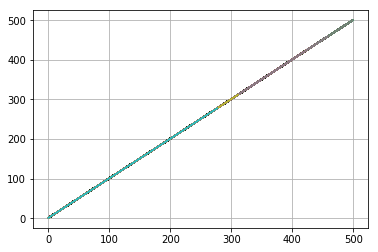

In [9]:
#
critic_optimizer = _optim(critic.parameters(), lr=_alpha_critic)
actor_optimizer  = _optim(actor.parameters(), lr=_alpha_actor)

#
try:
    rewards = []
    for n in range(n_episodes):
        # initialise S (select a starting state for the episode)
        state = env.reset()
        # to torch.autograd.Variable
        state = Variable(torch.Tensor([state]))        
        if torch.cuda.is_available():
            state = state.cuda()

        #
        critic_eligibilities = dict()
        actor_eligibilities  = dict()
        I = 1

        # initialise critic eligibilities ([re]set to zero(0))
        for i, group in enumerate(critic_optimizer.param_groups):
            zs = dict()
            for p in group["params"]:
                zs[p] = torch.zeros_like(p.data)
            critic_eligibilities[i] = zs

        # initialise actor eligibilities ([re]set to zero(0))
        for i, group in enumerate(actor_optimizer.param_groups):
            zs = dict()
            for p in group["params"]:
                zs[p] = torch.zeros_like(p.data)
            actor_eligibilities[i] = zs

        #
        cum_rewards = []
        cum_reward = 0
        done = False
        t = 0
        while not done:
            # render the environment
            env.render()

            # select action from policy
            probas = actor(state)
            # action = int(torch.max(probas, 1)[1].cpu().data)
            action = int(probas.multinomial().data)
            # take action A and observe next state S' and reward R
            observation, reward, done, _ = env.step(action)
            # to torch.autograd.Variable
            observation = Variable(torch.Tensor([observation]))        
            if torch.cuda.is_available():
                observation = observation.cuda()
            #
            cum_reward += reward
            cum_rewards.append(cum_reward)
            # compute TD error (if S' is terminal, then v(S', w)=0)
            error = reward + (_gamma * critic(observation)) - critic(state) # if not done else reward - critic(state)
            _delta = error.cpu().data
            
            #
            v = critic(state)
            v.backward()
            # update critic's parameters  
            for i, group in enumerate(critic_optimizer.param_groups):

                for p in group["params"]:
                    if p.grad is None:
                        continue
                    # retrieve current eligibility
                    z = critic_eligibilities[i][p]
                    # retrieve current gradient
                    grad = p.grad.data
                    # update eligibility
                    #
                    # torch.nn.utils.clip_grad_norm(critic.parameters(), 1.0)
                    z.mul_(_gamma * _lambda_critic).add_(I, grad)
                    # update parameters
                    p.data.add_(_alpha_critic * _delta * z)
                    # reset gradients
                    p.grad.detach_()
                    p.grad.zero_()

            #
            probas = actor(state)
            log_proba = torch.log(probas)[:, action]
            log_proba.backward()
            # update actor's parameters     
            for i, group in enumerate(actor_optimizer.param_groups):

                for p in group["params"]:
                    if p.grad is None:
                        continue
                    # retrieve current eligibility
                    z = actor_eligibilities[i][p]
                    # retrieve current gradient
                    grad = p.grad.data
                    # update eligibility
                    #
                    # torch.nn.utils.clip_grad_norm(actor.parameters(), 1.0)
                    z.mul_(_gamma * _lambda_actor).add_(I, grad)
                    # update parameters
                    p.data.add_(_alpha_actor * _delta * z)
                    # reset gradients
                    p.grad.detach_()
                    p.grad.zero_()

            #
            I = _gamma * I
            t = t + 1
            # update current state to next state (S = S')
            state = observation
        #
        print("episode {}, {} steps.".format(n+1, t+1))
        rewards.append(cum_rewards)
    # close environment
    env.close()

    #
    for rs in rewards:
        plt.plot(rs)
    plt.grid(True)
    plt.show()
finally:
    env.close()

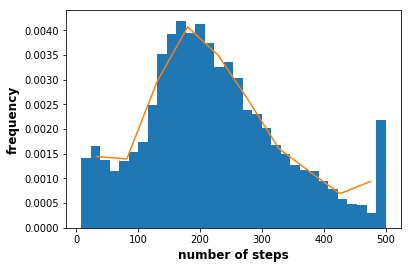

In [14]:
#
lengths = []
for rs in rewards:
    lengths.append(len(rs))
plt.hist(lengths, bins="auto", normed=True)
values, edges = np.histogram(lengths, normed=True, density=True)
centers = 0.5*(edges[1:]+edges[:-1])
plt.plot(centers, values)
plt.ylabel("frequency", fontsize=12, fontweight="bold")
plt.xlabel("number of steps", fontsize=12, fontweight="bold")
plt.show()